# Administration: Deploy automatic notifications

> * ✏️ Needs Configuration
* 🗄️ Administration
* 🔔 Notifications

To optimize your notebook's utility, consider configuring it to alert someone of a notable event. For example, a publisher could be notified that their web map contains a broken layer URL, or an admin could be notified when certain users haven't logged on in over a month. Notifications may arrive as an email or text message - or they could take the form of a tweet or a Slack post. There are many ways to use native Python libraries to send notifications through external services. This notebook will walk you through the technical details of how to configure these external services for your hosted notebooks and provide you the sample code needed to control these services.

## Security

Before writing code that connects to any external service, it is vital to keep security in mind. Notebooks are commonly shared and code is copied and pasted, sometimes leading to passwords and private keys landing in the wrong hands.

**Passwords and private keys should NEVER be stored in plaintext in a notebook**. There are many paradigms to securely store passwords and private keys. We will be storing all 'secrets' in a [private CSV item](https://www.esri.com/arcgis-blog/products/arcgis-online/sharing-collaboration/managing-security-and-findability-of-items-with-the-arcgis-sharing-model/) that is only accessible by you and your GIS administrator. 

> __Note__: that although this is more secure than storing your passwords as a plain string in a notebook, this is __NOT__ a totally secure solution—Portal items aren't encrypted in the underlying server where they are stored. Consider storing your secrets in an encrypted files in `/arcgis/home/`.

Run the below cells to import necessary libraries, connect to our Portal, and create a new private blank CSV item.

In [9]:
# First, import some libraries we'll need, and connect to our GIS
import csv
import os
import smtplib
import requests
import logging
log = logging.getLogger()

from arcgis.gis import GIS

gis = GIS("home")

In [10]:
SECRET_CSV_ITEM_ID = '180641b2dfc549a5aa214dfbf68ec146'

In [11]:
def get_secrets(gis=gis,
                secret_csv_item_id = SECRET_CSV_ITEM_ID):
    """Returns the secrets.csv file as a dict of secret_key : secret_value"""
    item = gis.content.get(secret_csv_item_id)
    with open(item.download(), 'r') as local_item_file:
        reader = csv.DictReader(local_item_file)
        return { rows['secret_key'] : rows['secret_value'] for rows in reader}

In [12]:
secrets = get_secrets()

## Email Notifications

Emails might be the gold standard for notifications. Emails are simple and sortable, and everyone can receive them. Emails can only be sent by an external service, so Python must know how to connect to that service. The most common way to do this is to connect to an SMTP Server.

### SMTP Server

The builtin [`smtplib`](https://docs.python.org/3/library/smtplib.html#module-smtplib) library makes it easy to connect an external email SMTP server, whether that's a server you manage or a commercial offering (e.g. Gmail).

The below function provides an outline for sending emails via an external SMTP server. Make sure to update the string values of `smtp_server_url`, `smt_server_port`, `sender`, and `username` to reflect your own SMTP server. Add your SMTP server password to your secrets.csv item with the key `'smtp_email_password'`, so you can access it in a secure way.

In [13]:
def send_email_smtp(recipients, message,
                    subject="Message from your Notebook"):
    """Sends the `message` string to all of the emails in the 
    `recipients` list using the configured SMTP email server. 
    """
    try:
        # Set up server and credential variables
        smtp_server_url = "smtp.gmail.com"
        smtp_server_port = 587
        sender = "arcgispyapibot@gmail.com"
        username = "arcgispyapibot"
        password = secrets["smtp_email_password"]

        # Instantiate our server, configure the necessary security
        server = smtplib.SMTP(smtp_server_url, smtp_server_port)
        server.ehlo()
        server.starttls() # Needed if TLS is required w/ SMTP server
        server.login(username, password)
    except Exception as e:
        log.warning("Error setting up SMTP server, couldn't send " +
                    f"message to {recipients}")
        raise e

    # For each recipient, construct the message and attempt to send
    did_succeed = True
    for recipient in recipients:
        try:
            message_body = '\r\n'.join(['To: {}'.format(recipient),
                                        'From: {}'.format(sender),
                                        'Subject: {}'.format(subject),
                                        '',
                                        '{}'.format(message)])
            message_body = message_body.encode("utf-8")
            server.sendmail(sender, [recipient], message_body)
            print(f"SMTP server returned success for sending email "\
                  f"to {recipient}")
        except Exception as e:
            log.warning(f"Failed sending message to {recipient}")
            log.warning(e)
            did_succeed = False
    
    # Cleanup and return
    server.quit()
    return did_succeed

Now that you have updated the above function with your SMTP server information, run the below cell to send a test email. The function should return `True`, print out no warnings, and send an email to your test recipient! You can use this function anywhere in your code to send out an email.

In [14]:
send_email_smtp(recipients = ['dvitale@esri.com'],
                message = "Hello World!")

SMTP server returned success for sending email to dvitale@esri.com


True

<img src=" 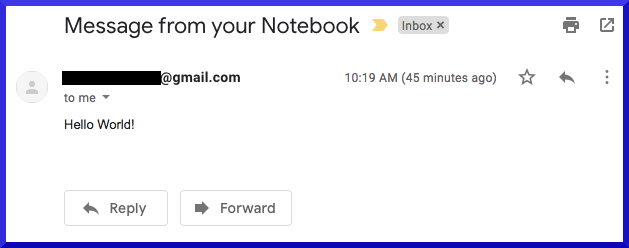">

### Text Messages via Email

Many major cellular providers offer a mechanism to send text messages (SMS or MMS) via email. You just need to know what the phone number is, and what cellular provider that phone number is under. For example, if phone number _555-123-4567_ has AT&T as their cellular provider, the below code cell can be run to send that number a text message.

In [35]:
send_email_smtp(recipients = ['5551234567@txt.att.net'],
                message = "Hello World!")

True

<img src=" 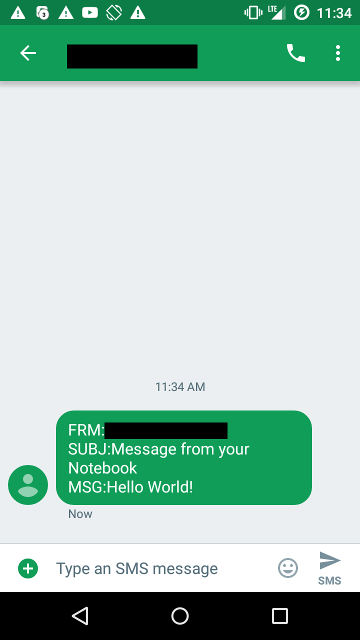">

Check your area's cellular providers to see if this functionality is supported. Standard messaging and data rates would apply. The below table outlines some of the common cellular providers' email formats—it is not a complete or authoritative list.

Cellular Provider | SMS email | MMS email |
---|---|---|
AT&T | number@txt.att.net | number@mms.att.net |
T-Mobile | number@tmomail.net | number@tmomail.net |
Verizon |number@vtext.com | number@vzwpix.com |
Sprint | number@messaging.sprintpcs.com | number@pm.sprint.com |
U.S. Cellular | number@email.uscc.net | number@mms.uscc.net |
Virgin Mobile | number@vmobl.com | number@vmpix.com |
Boost Mobile | number@sms.myboostmobile.com | number@myboostmobile.com | 
Cricket | number@sms.cricketwireless.net | number@mms.cricketwireless.net |
Google Fi (Project Fi) | number@msg.fi.google.com | number@msg.fi.google.com |
Tracfone | - | number@mmst5.tracfone.com |
Metro PCS | number@mymetropcs.com | number@mymetropcs.com |
Republic Wireless | number@text.republicwireless.com | - |
Ting | number@message.ting.com | - |
Consumer Cellular | number@mailmymobile.net | - |
C-Spire | number@cspire1.com | - |
Page Plus | number@vtext.com | - | 

Source: https://20somethingfinance.com/how-to-send-text-messages-sms-via-email-for-free/

## Zapier via Tweet 

A Zapier "Zap" has been set up which will post a tweet when the `zapier_tweet_webhook_url` endpoint is hit with the correct `POST` HTTP request.

In [27]:
def tweet_via_zapier(message):
    """Sends the `message` string as a tweet via zapier."""
    # Do the POST request that sends the tweet
    secrets = get_secrets()
    response = requests.post(secrets['zapier_tweet_webhook_url'],
                             data={"message" : message})
    
    # Check that the response looks OK; warn the user if it doesn't
    if response.ok:
        return True
    else:
        log.warning("Zapier tweet POST returned a bad response:")
        log.warning(response.text)
        return False

Now, call this function and verify that your Twitter account posted the message! You can use this function anywhere in your code to send out a tweet.

In [15]:
tweet_via_zapier("Hello World!")

True

<img src=" 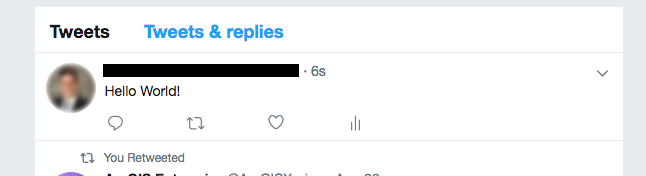">